#### Text Classification

In [1]:
!pip install ibm_watson

In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

In [3]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('toTranslate.csv', index_col = 0)

df

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05
...,...,...,...,...,...,...,...,...,...
394,169,5.0,-1,1,es,-2,NaN,El trabajo pretende ofrecer una visión del uso...,2015-07-05
395,169,4.0,-1,2,es,-1,NaN,El paper está bien escrito y de fácil lectura....,2015-07-05
396,170,4.0,-1,1,es,0,NaN,Observación de fondo: No se presenta un ejemp...,2015-07-05
397,170,3.0,1,2,es,-1,NaN,Se propone un procedimiento para elaborar máqu...,2015-07-05


In [6]:
# https://www.youtube.com/watch?v=_jLRKUuBUtY

### IBM Translator

In [7]:
# https://cloud.ibm.com/apidocs/language-translator?code=python

In [8]:
apikey = 'eF6iPG4CDZNENRGyvUvsuZUtrDDq3u9IkoXNhhOMpD-n'
url = 'https://api.us-east.language-translator.watson.cloud.ibm.com/instances/91361511-8110-41d5-9095-36c16f110634'

In [9]:
# Import dependencies
from ibm_watson import LanguageTranslatorV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator

In [10]:
# Setup service

authenticator = IAMAuthenticator(apikey)
langTrans = LanguageTranslatorV3(version='2020-12-15', authenticator = authenticator)
langTrans.set_service_url(url)

In [11]:
# Translate the text column in english

df["translate_eng"] = df["text"].apply(lambda x: langTrans.translate(x, model_id='es-en').get_result())
df.head()

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,{'translations': [{'translation': '-The articl...
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,{'translations': [{'translation': 'The article...
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,{'translations': [{'translation': '-The theme ...
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,{'translations': [{'translation': 'An ICT use ...
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,{'translations': [{'translation': 'The authors...


In [12]:
# Extract just the translated texts

df["translate_eng"] = df["translate_eng"].apply(lambda x: x['translations'][0]['translation'])

df.head(10)

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,-The article addresses a very relevant and con...
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,The article presents practical recommendations...
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,-The theme is very interesting and can be of m...
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,An ICT use experience for academic collaborati...
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,The authors describe a methodology for develop...
5,2,4.0,2,1,es,1,NaN,Este trabajo propone un nuevo enfoque basado e...,2010-07-05,This paper proposes a new approach based on [2...
6,2,3.0,2,2,en,1,NaN,This paper aims to show new deployment alterna...,2010-07-05,This paper aims to show new deployment alterna...
7,2,3.0,0,3,en,-1,NaN,The paper is well structured. It follows a log...,2010-07-05,The paper is well structured. It follows a log...
8,3,4.0,2,1,es,2,muy buen trabajo,Se realiza un trabajo de modelamiento de encri...,2010-07-05,A novel quantum encryption modelling work is p...
9,3,2.0,-2,2,es,-1,NaN,Este paper involucra el desarrollo de una apli...,2010-07-05,This paper involves the development of an appl...


In [13]:
# ICT means Information and Communication Technology

In [14]:
# Length of all the texts tranlated in english
df["length_translate_eng"] = df["translate_eng"].apply(len)
df.head()

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng,length_translate_eng
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,-The article addresses a very relevant and con...,536
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,The article presents practical recommendations...,606
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,-The theme is very interesting and can be of m...,1235
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,An ICT use experience for academic collaborati...,1300
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,The authors describe a methodology for develop...,1812


In [15]:
df.shape

(399, 11)

In [52]:
# # Check for NaN under the entire DataFrame 
# df.isnull().sum()

In [50]:
# Check for NaN under a specific DataFrame column
df["translate_eng"].isnull().sum()

0

### Data Preprocessiong

In [23]:
# Data cleaning

# convert to lower-case, remove square brackets, special caracters, numbers, and punctuations

def text_clean(review):
    review = review.lower()
    review = re.sub('\[.*?\]', '', review)
    review = re.sub('[%s]' % re.escape(string.punctuation), '', review)
    review = re.sub('\w*\d\w*', '', review)
    review = re.sub('\n', '', review)# remove new lines
    review = re.sub('…', '', review)
    review = re.sub('“', '', review)
    review = re.sub('”', '', review)
    review = re.sub(',,', '', review)
    review = re.sub('`', '', review)
    return review

#review_clean = lambda x: text_clean(x)


In [24]:
df['clean_eng_text'] = df["translate_eng"].apply(text_clean)
df.head()

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng,length_translate_eng,clean_eng_text
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,-The article addresses a very relevant and con...,536,the article addresses a very relevant and cont...
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,The article presents practical recommendations...,606,the article presents practical recommendations...
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,-The theme is very interesting and can be of m...,1235,the theme is very interesting and can be of mu...
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,An ICT use experience for academic collaborati...,1300,an ict use experience for academic collaborati...
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,The authors describe a methodology for develop...,1812,the authors describe a methodology for develop...


In [25]:
# Length of all the clean translated texts
df["length_clean_eng_text"] = df["clean_eng_text"].apply(len)
df.head()

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng,length_translate_eng,clean_eng_text,length_clean_eng_text
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,-The article addresses a very relevant and con...,536,the article addresses a very relevant and cont...,500
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,The article presents practical recommendations...,606,the article presents practical recommendations...,599
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,-The theme is very interesting and can be of m...,1235,the theme is very interesting and can be of mu...,1173
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,An ICT use experience for academic collaborati...,1300,an ict use experience for academic collaborati...,1203
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,The authors describe a methodology for develop...,1812,the authors describe a methodology for develop...,1723


In [26]:
# Find the lenght of the clean text

df['clean_eng_text'] = df['clean_eng_text'].apply(lambda x: " ".join(word for word in x.split() if word not in stopwords.words('english')))
df["length_clean_eng_text"] = df["clean_eng_text"].apply(len)
df.head()

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng,length_translate_eng,clean_eng_text,length_clean_eng_text
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,-The article addresses a very relevant and con...,536,article addresses relevant contingent problem ...,372
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,The article presents practical recommendations...,606,article presents practical recommendations dev...,426
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,-The theme is very interesting and can be of m...,1235,theme interesting much help guide incorporate ...,813
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,An ICT use experience for academic collaborati...,1300,ict use experience academic collaboration expl...,908
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,The authors describe a methodology for develop...,1812,authors describe methodology developing collab...,1210


In [27]:
# Lemmatize cleaned text

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])


In [28]:
df["Lemma_clean_eng_text"]= df["clean_eng_text"].apply(lemmatize_text)

df.head()

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng,length_translate_eng,clean_eng_text,length_clean_eng_text,Lemma_clean_eng_text
0,0,4.0,1,1,es,0,NaN,- El artículo aborda un problema contingente y...,2010-07-05,-The article addresses a very relevant and con...,536,article addresses relevant contingent problem ...,372,article address relevant contingent problem in...
1,0,4.0,1,2,es,1,NaN,El artículo presenta recomendaciones prácticas...,2010-07-05,The article presents practical recommendations...,606,article presents practical recommendations dev...,426,article present practical recommendation devel...
2,0,5.0,1,3,es,1,NaN,- El tema es muy interesante y puede ser de mu...,2010-07-05,-The theme is very interesting and can be of m...,1235,theme interesting much help guide incorporate ...,813,theme interesting much help guide incorporate ...
3,1,4.0,2,1,es,1,NaN,Se explica en forma ordenada y didáctica una e...,2010-07-05,An ICT use experience for academic collaborati...,1300,ict use experience academic collaboration expl...,908,ict use experience academic collaboration expl...
4,1,4.0,2,3,es,0,NaN,Los autores describen una metodología para des...,2010-07-05,The authors describe a methodology for develop...,1812,authors describe methodology developing collab...,1210,author describe methodology developing collabo...


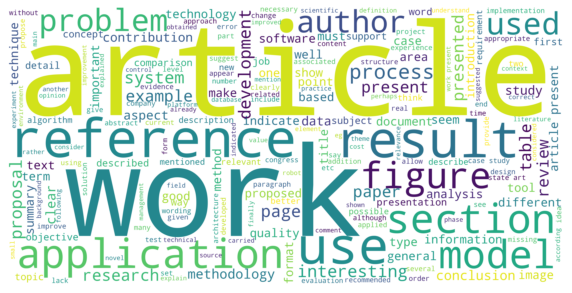

In [29]:
# Build a word cloud of all the reviews 

# Text of all words in column "Lemma_text"
text = " ".join(review for review in df["Lemma_clean_eng_text"].astype(str))

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", scale =10, width=800, height=400).generate(text)

# Display the generated image:

plt.figure( figsize=(10,10))
plt.tight_layout(pad=0)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
# Find the 3 tops largest reviews

df.nlargest(3,"length_clean_eng_text" )

,level_0,confidence,evaluation,id,lan,orientation,remarks,text,timespan,translate_eng,length_translate_eng,clean_eng_text,length_clean_eng_text,Lemma_clean_eng_text
326,135,4.0,-2,2,es,-1,El artículo está desordenado. La propuesta de ...,"El trabajo se titula ""Madurez actual del desar...",2015-07-05,"The work is titled ""Current Maturity of Softwa...",5825,work titled current maturity software testing ...,3869,work titled current maturity software testing ...
258,111,5.0,-1,4,es,-1,**El principal problema detectado es el uso de...,"• Revisar los conceptos de metodologías, métod...",2014-07-05,"• Review the concepts of methodologies, method...",4607,• review concepts methodologies methods models...,3156,• review concept methodology method model used...
70,28,5.0,-2,1,es,-2,NaN,El trabajo es de baja calidad académica (descr...,2010-07-05,The work is of low academic quality (it descri...,4375,work low academic quality describes project id...,2887,work low academic quality describes project id...


In [31]:
# # Checking one of the top largest row
# df['Lemma_clean_eng_text'][326]

#### Save the dataframe as CSV file for further used in sentiment analysis notebook

In [32]:
# Delect the CSV file

# I'm doing this, because it can happened that I run my notebook many times, and I will like to have a last version of my CSV file each time.
if os.path.exists("englishTranslationLemma.csv"):
    os.remove("englishTranslationLemma.csv")
else:
    print("The file does not exist")

In [33]:
# Save df dataframe in a csv file
df.to_csv('englishTranslationLemma.csv')

### Predict the preliminare_decision

In [34]:
df1 = pd.read_csv('preliminary_decision.csv', index_col = 0)

df1.head()

,book_id,preliminary_decision
0,1,accept
1,2,accept
2,3,accept
3,4,accept
4,5,accept


In [35]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 171
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   book_id               172 non-null    int64 
 1   preliminary_decision  172 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB


In [36]:
# Extract 2 columns: level_0 and Lemma_clean_eng_text

df_new = df[['level_0','Lemma_clean_eng_text']]

df_new.head()

,level_0,Lemma_clean_eng_text
0,0,article address relevant contingent problem in...
1,0,article present practical recommendation devel...
2,0,theme interesting much help guide incorporate ...
3,1,ict use experience academic collaboration expl...
4,1,author describe methodology developing collabo...


In [37]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 0 to 398
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   level_0               399 non-null    int64 
 1   Lemma_clean_eng_text  399 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.4+ KB


In [38]:
# Checking 1st row before concatanation
df_new['Lemma_clean_eng_text'][0]

'article address relevant contingent problem includes national diagnosis use good practice solution good concrete practice language right article feel like concatenation three different article result survey good security practice incorporation good practice order section would better reflects order revised version article validation kind even expert evaluation'

In [39]:
# Merge rows by same value in the column ('level_0')
d = {'Lemma_clean_eng_text': lambda x: ' '.join(x)}
df_newly = df_new.groupby(df_new['level_0']).aggregate(d)
df_newly.head()

,Lemma_clean_eng_text
level_0,
0,article address relevant contingent problem in...
1,ict use experience academic collaboration expl...
2,paper proposes new approach based support reco...
3,novel quantum encryption modelling work perfor...
4,novel proposal well structured correctly writt...


In [40]:
# Checking 1st row after concatanation
df_newly['Lemma_clean_eng_text'][0]

'article address relevant contingent problem includes national diagnosis use good practice solution good concrete practice language right article feel like concatenation three different article result survey good security practice incorporation good practice order section would better reflects order revised version article validation kind even expert evaluation article present practical recommendation development secure software best practice recommended developing software proactive face attack described cost analysis software development practice performed based review practice proposed bibliography contrast data obtained survey company finally guide recommended would ideal apply proposed guide company involved survey used give way evaluate effectiveness independently theme interesting much help guide incorporate safety practice presentation description stage use practice development secure software real state software development chile indicated paper cannot achieved survey total pr

In [41]:
## Merge two dataframes
df_merge = pd.merge(df1, df_newly, left_index=True, right_index=True)
df_merge.head()

,book_id,preliminary_decision,Lemma_clean_eng_text
0,1,accept,article address relevant contingent problem in...
1,2,accept,ict use experience academic collaboration expl...
2,3,accept,paper proposes new approach based support reco...
3,4,accept,novel quantum encryption modelling work perfor...
4,5,accept,novel proposal well structured correctly writt...


In [42]:
df_merge.shape

(169, 3)

In [43]:
# Check the rows' values
df_merge['preliminary_decision'].unique()

array(['accept', 'probably reject', 'reject', 'no decision'], dtype=object)

In [44]:
# Drop 'probably reject' & 'no decision' rows 


df_merge.drop(df_merge[df_merge['preliminary_decision'] == 'probably reject' ].index , inplace=True)

df_merge.drop(df_merge[df_merge['preliminary_decision'] == 'no decision' ].index , inplace=True)

df_merge.shape

(161, 3)

In [45]:
# Check the rows' values
df_merge['preliminary_decision'].unique()

array(['accept', 'reject'], dtype=object)

## Models training

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

In [47]:
from sklearn.model_selection import train_test_split

independent_var = df_merge.Lemma_clean_eng_text
target_var = df_merge.preliminary_decision

X_train, X_test, y_train, y_test = train_test_split(independent_var, target_var, random_state = 13) 

print('X_train: ', len(X_train))
print('X_test: ', len(X_test))
print('y_train: ', len(y_train))
print('y_test: ', len(y_test))

X_train:  120
X_test:  41
y_train:  120
y_test:  41


### Naive Bayes

In [48]:
# Unigram

cv = CountVectorizer(ngram_range=(1, 1))
clf = MultinomialNB()

naive_bayes = Pipeline([('vectorizer', cv), ('classifier', clf)])

# Fit the model and make predictions

naive_bayes.fit(X_train, y_train)

predictions = naive_bayes.predict(X_test)

# # Model Accuracy, how often is the classifier correct?

print('Accuracy score: ', accuracy_score(y_test, predictions))

Accuracy score:  0.7317073170731707


In [49]:
# Bigram

cv = CountVectorizer(ngram_range=(2, 2))

clf = MultinomialNB()

naive_bayes = Pipeline([('vectorizer', cv), ('classifier', clf)])

# Fit the model and make predictions

naive_bayes.fit(X_train, y_train)

predictions = naive_bayes.predict(X_test)

# # Model Accuracy, how often is the classifier correct?

print('Accuracy score: ', accuracy_score(y_test, predictions))

Accuracy score:  0.7804878048780488
